# FastClouds
This is my project for the first week fo the fast.ai course v5. It is a re-implementation of Jeremy's 'bird vs forests' notebook. This is for my own learning experience.

There are three broad categorised of clouds as per the work of Luke Howard in "Essay of the Modifications of Clouds" (1803) (https://www.weather.gov/jetstream/corefour): Cirrus, Cumulus, Stratus

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/working/__notebook__.ipynb


In [2]:
# import shutil

# shutil.rmtree('./cloud_types/')

In [3]:
!pip install -Uqq fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

In [4]:
from fastcore.all import *
import time

In [5]:
def search_duckduckgo(term, max_images=200):
    """
    Search duckduckgo images for the term
    """
    url = 'https://duckduckgo.com/'
    res = urlread(url, data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls, data = set(),{'next':1}
    while len(urls) < max_images and 'next' in data:
        data = urljson(requestUrl, data = params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [6]:
urls = search_duckduckgo('cirrus clouds', max_images = 2)
urls[1]

'https://images.fineartamerica.com/images-medium-large-5/cirrus-clouds-anthony-cooperscience-photo-library.jpg'

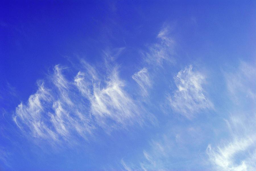

In [7]:
from fastdownload import download_url
dest = 'cirrus.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now lets od the same for another cloud genus

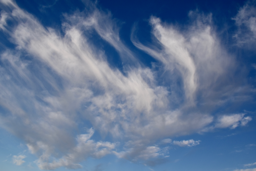

In [8]:
download_url(search_duckduckgo('cumulus clouds', max_images=1)[0], 'cumulus.jpg', show_progress = False)
Image.open('cumulus.jpg').to_thumb(256,256)

Now grab 200 of each of our genus's

In [9]:
searches = 'cirrus', 'stratus', 'cumulus'
path = Path('cloud_types')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_duckduckgo(f'{o} clouds'))
    resize_images(path/o, max_size=400, dest=path/o)

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

## Train a model

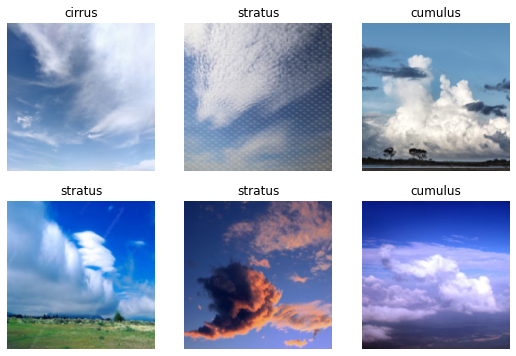

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
# resnet18, resnet34, resnet50, resnet101, resnet152
# densenet121, densenet169, densenet201, densenet161
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.821304,0.933634,0.345133,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.756553,0.826219,0.265487,00:02
1,0.589277,0.761725,0.221239,00:02
2,0.472021,0.722812,0.221239,00:02


# Use the model

In [13]:
is_cirrus, _, prob = learn.predict(PILImage.create('cirrus.jpg'))
print(f'This is a: {is_cirrus}')
print(f'Probability it is a cirrus: {prob[0]:.4f}')

This is a: cirrus
Probability it is a cirrus: 0.9992


In [14]:
is_cumulus, _, prob = learn.predict(PILImage.create('cumulus.jpg'))
print(f'This is a: {is_cumulus}')
print(f'Probability it is a cumulus: {prob[0]:.4f}')

This is a: cumulus
Probability it is a cumulus: 0.0910
